## 1. 데이터 읽기와 전처리, 및 확인

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. CSV 파일 로드
data = pd.read_csv('미국 옥수수 선물 과거 데이터 (1).csv')  # 'your_file.csv'를 실제 파일 이름으로 변경

# 2. 데이터 분할 (80% 학습, 20% 테스트)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# 3. 결과 확인
print("학습용 데이터 크기:", train_data.shape)
print("백테스팅용 데이터 크기:", test_data.shape)

# 4. 필요하면 저장
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

학습용 데이터 크기: (868, 7)
백테스팅용 데이터 크기: (217, 7)


In [11]:
!pip install holidays

In [17]:
import pandas as pd
import holidays  # 미국 공휴일 데이터를 가져오기 위한 라이브러리

# 1. 데이터 로드
data = pd.read_csv('train_data.csv')
data.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change_Pct']

# 2. 날짜를 인덱스로 설정 및 요일 컬럼 추가
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Weekday'] = data.index.day_name()

# 3. 거래량 전처리: 'K' 제거 및 숫자 변환 (예: '223.84K' -> 223840)
data['Volume'] = data['Volume'].str.replace('K', '').astype(float) * 1000

# 개선: 거래량 정규화 (평균 대비 비율)
data['Volume_Norm'] = data['Volume'] / data['Volume'].mean()

# 4. 공휴일 처리 개선
# 미국 공휴일 데이터 로드 (holidays 라이브러리 사용)
us_holidays = holidays.US(years=[2023, 2024, 2025])

# 공휴일 여부 컬럼 추가
data['IsHoliday'] = data.index.map(lambda x: x in us_holidays)

# 월요일 데이터 확인 및 공휴일 처리
data['IsMonday'] = data['Weekday'] == 'Monday'
data['IsTuesday'] = data['Weekday'] == 'Tuesday'

# 공휴일인 월요일 데이터는 제외 (또는 보간 처리 가능)
data_monday = data[data['IsMonday'] & ~data['IsHoliday']].copy()

# 5. 금요일 데이터와 월요일 시초가 연결
data.sort_index(ascending=True, inplace=True)
data['NextOpen'] = data['Open'].shift(-1)  # 다음 거래일 시초가

# 금요일 데이터에 월요일 시초가를 연결
data['MondayOpen'] = None
for i in range(len(data)):
    if data.iloc[i]['Weekday'] == 'Friday':
        for j in range(i + 1, len(data)):
            if data.iloc[j]['IsMonday'] and not data.iloc[j]['IsHoliday']:
                data.iloc[i, data.columns.get_loc('MondayOpen')] = data.iloc[j]['Open']
                break
            elif data.iloc[j]['IsTuesday']:  # 월요일이 공휴일이면 화요일 시초가 사용
                data.iloc[i, data.columns.get_loc('MondayOpen')] = data.iloc[j]['Open']
                break

# 6. 금요일 데이터 추출 및 계산
data['Fri_Close_Low'] = data['Close'] - data['Low']  # 종가-저가 차이
data['Fri_High_Low'] = data['High'] - data['Low']   # 고가-저가 차이 (변동폭)

# 개선: 갭을 비율(%)로 계산
data['Gap'] = data['MondayOpen'] - data['Close']  # 기존 갭 (절대값)
data['Gap_Pct'] = (data['Gap'] / data['Close']) * 100  # 갭 비율 (%)

# 금요일 데이터만 필터링
data_friday = data[data['Weekday'] == 'Friday'].copy()

# 7. 결측치 확인 및 처리
print("결측치 확인:")
print(data_friday.isna().sum())
data_friday.dropna(subset=['MondayOpen', 'Gap', 'Gap_Pct'], inplace=True)

# 8. 결과 확인
print("전처리된 데이터 (금요일 기준):")
print(data_friday[['Close', 'Low', 'Fri_Close_Low', 'Fri_High_Low', 'Volume', 'Volume_Norm', 'MondayOpen', 'Gap', 'Gap_Pct']].head())

# 9. 전처리된 데이터 저장
data_friday.to_csv('processed_natural_gas_data.csv')

결측치 확인:
Close            0
Open             0
High             0
Low              0
Volume           7
Change_Pct       0
Weekday          0
Volume_Norm      7
IsHoliday        0
IsMonday         0
IsTuesday        0
NextOpen         0
MondayOpen       0
Fri_Close_Low    0
Fri_High_Low     0
Gap              0
Gap_Pct          0
dtype: int64
전처리된 데이터 (금요일 기준):
             Close     Low  Fri_Close_Low  Fri_High_Low    Volume  \
Date                                                                
2021-01-01  485.75  485.75           0.00          0.00       NaN   
2021-01-08  496.25  492.50           3.75          7.00  163270.0   
2021-01-15  531.50  527.75           3.75          8.75  167500.0   
2021-01-22  500.50  499.25           1.25         23.50  289550.0   
2021-01-29  547.00  533.25          13.75         20.50  279610.0   

            Volume_Norm MondayOpen   Gap   Gap_Pct  
Date                                                
2021-01-01          NaN     487.25   1.5  0.308

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 868 entries, 2020-12-31 to 2025-04-07
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          868 non-null    float64
 1   Open           868 non-null    float64
 2   High           868 non-null    float64
 3   Low            868 non-null    float64
 4   Volume         853 non-null    float64
 5   Change_Pct     868 non-null    object 
 6   Weekday        868 non-null    object 
 7   Volume_Norm    853 non-null    float64
 8   IsHoliday      868 non-null    bool   
 9   IsMonday       868 non-null    bool   
 10  IsTuesday      868 non-null    bool   
 11  NextOpen       867 non-null    float64
 12  MondayOpen     187 non-null    object 
 13  Fri_Close_Low  868 non-null    float64
 14  Fri_High_Low   868 non-null    float64
 15  Gap            187 non-null    object 
 16  Gap_Pct        187 non-null    object 
dtypes: bool(3), float64(9), object(5)
m

In [3]:
data.tail()

,Close,Open,High,Low,Volume,Change_Pct,Weekday,Volume_Norm,IsHoliday,IsMonday,IsTuesday,NextOpen,MondayOpen,Fri_Close_Low,Fri_High_Low,Gap,Gap_Pct
Date,,,,,,,,,,,,,,,,,
2025-03-28,453.25,450.25,454.00,442.00,206960.0,0.72%,Friday,1.516301,False,False,False,453.00,453.0,11.25,12.00,-0.25,-0.055157
2025-03-31,457.25,453.00,459.25,444.00,282800.0,0.88%,Monday,2.071945,False,True,False,457.75,None,13.25,15.25,NaN,NaN
2025-04-01,461.75,457.75,465.00,454.00,179570.0,0.98%,Tuesday,1.315627,False,False,True,457.75,None,7.75,11.00,NaN,NaN
2025-04-04,460.25,457.75,462.50,449.25,NaN,0.60%,Friday,NaN,False,False,False,455.60,455.6,11.00,13.25,-4.65,-1.01032
2025-04-07,458.90,455.60,459.13,454.30,4640.0,-0.29%,Monday,0.033995,False,True,False,NaN,None,4.60,4.83,NaN,NaN


In [4]:
data_friday.tail()

,Close,Open,High,Low,Volume,Change_Pct,Weekday,Volume_Norm,IsHoliday,IsMonday,IsTuesday,NextOpen,MondayOpen,Fri_Close_Low,Fri_High_Low,Gap,Gap_Pct
Date,,,,,,,,,,,,,,,,,
2025-03-07,469.25,464.75,471.00,460.75,191870.0,1.13%,Friday,1.405743,False,False,False,458.0,458.0,8.50,10.25,-11.25,-2.397443
2025-03-14,445.50,443.25,443.25,443.25,30.0,-1.76%,Friday,0.000220,False,False,False,460.0,460.0,2.25,0.00,14.5,3.25477
2025-03-21,464.25,467.25,469.75,461.25,182430.0,-1.01%,Friday,1.336581,False,False,False,464.5,464.5,3.00,8.50,0.25,0.05385
2025-03-28,453.25,450.25,454.00,442.00,206960.0,0.72%,Friday,1.516301,False,False,False,453.0,453.0,11.25,12.00,-0.25,-0.055157
2025-04-04,460.25,457.75,462.50,449.25,NaN,0.60%,Friday,NaN,False,False,False,455.6,455.6,11.00,13.25,-4.65,-1.01032


## 2. 분석 목표(월요일 시초가 움직임) 시각화 

- **갭 정의 및 범주화**
  - 갭 방향: 상승/하락/없음
  - 갭 크기: 절대값 기준 범주화

- **월별/계절별 분석**
  - 월별 갭 방향 비율
  - 겨울철(11-2월) vs 여름철(5-8월) 비교
  - 연도별/월별 갭 패턴

- **특이 케이스 분석**
  - 비정상 갭(±10% 이상) 탐지
  - 계절성 영향 확인

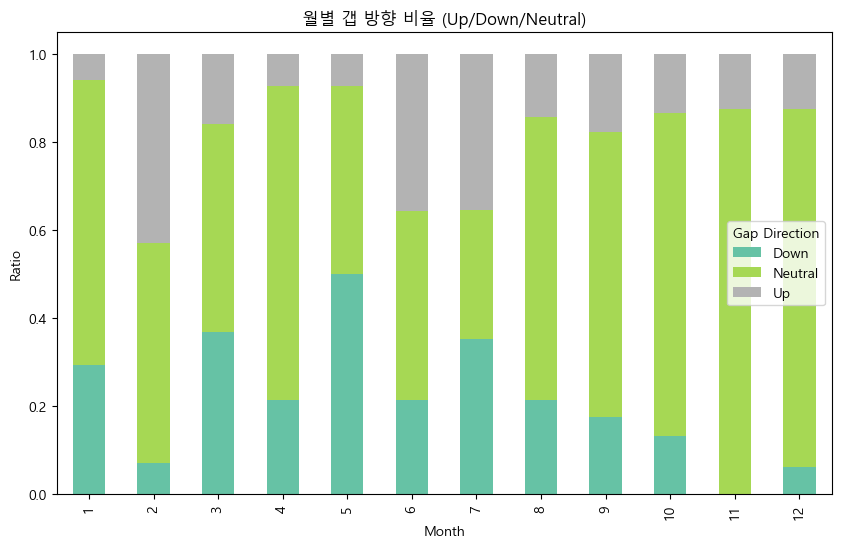

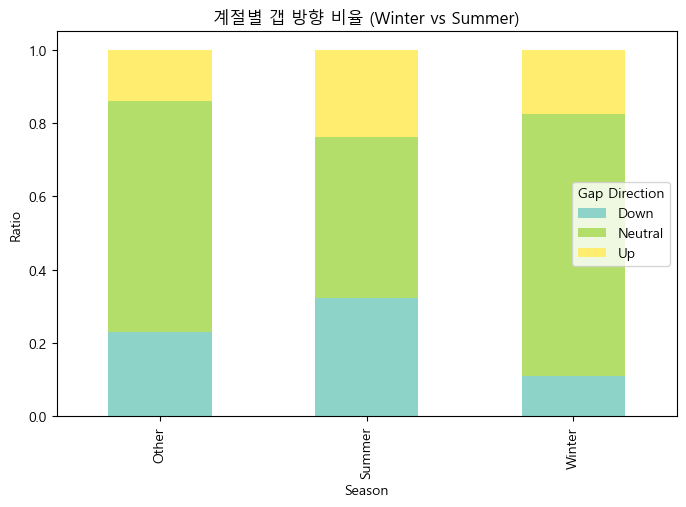


갭 비율 이상치 (±10% 이상):
             Close  MondayOpen    Gap_Pct  Season
Date                                             
2023-07-14  599.75       512.0 -14.631096  Summer


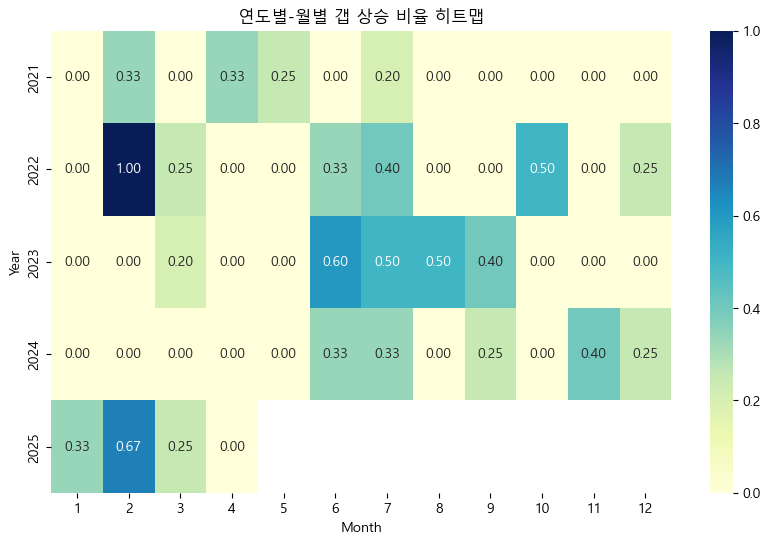

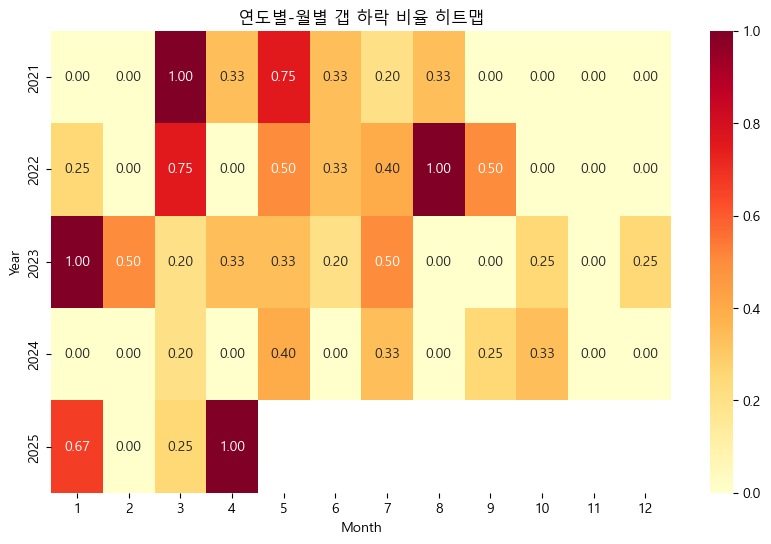

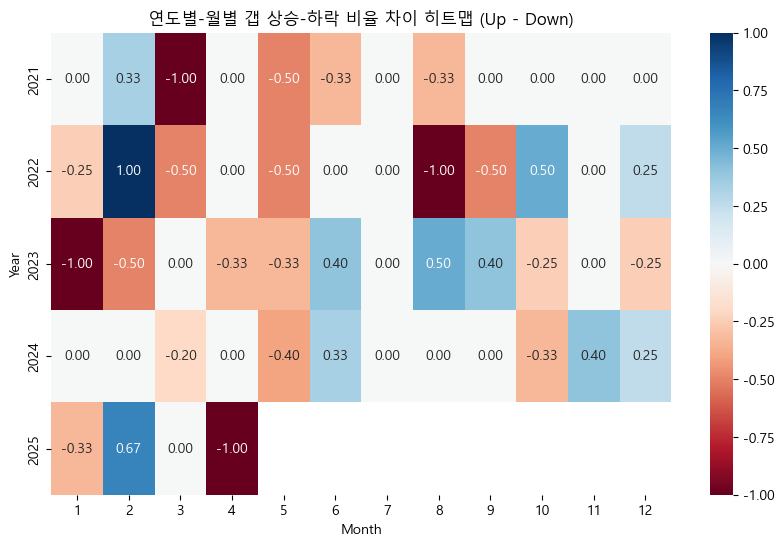

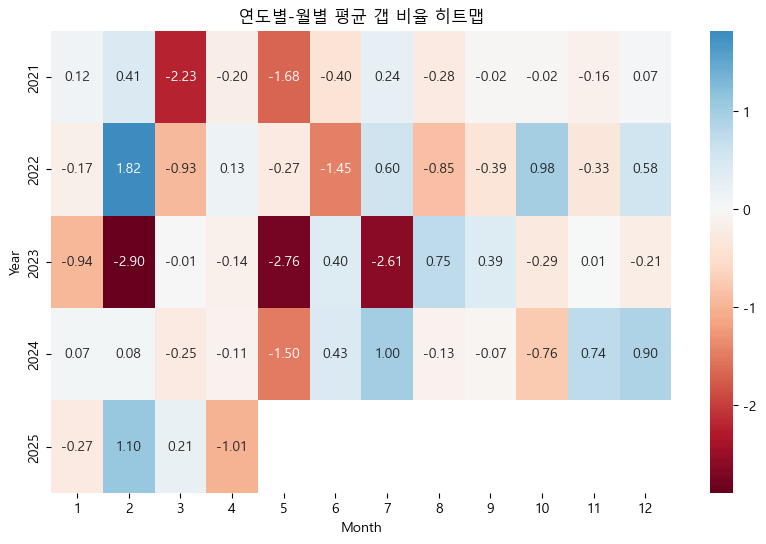

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# 1. 데이터 로드
data_friday = pd.read_csv('processed_natural_gas_data.csv')
data_friday['Date'] = pd.to_datetime(data_friday['Date'])
data_friday.set_index('Date', inplace=True)

# 2. 갭 방향 정의
def classify_gap(gap_pct):
    if gap_pct > 0.5:
        return 'Up'
    elif gap_pct < -0.5:
        return 'Down'
    else:
        return 'Neutral'

data_friday['Gap_Direction'] = data_friday['Gap_Pct'].apply(classify_gap)

# 3. 갭 크기 범주화
bins = [-float('inf'), -2, -1, 0, 1, 2, float('inf')]
labels = ['<-2%', '-2% to -1%', '-1% to 0%', '0% to 1%', '1% to 2%', '>2%']
data_friday['Gap_Size_Category'] = pd.cut(data_friday['Gap_Pct'], bins=bins, labels=labels)

# 4. 월별 갭 비율 계산
data_friday['Month'] = data_friday.index.month
monthly_gap_direction = data_friday.groupby('Month')['Gap_Direction'].value_counts(normalize=True).unstack().fillna(0)

# 5. 시각화 1: 월별 갭 방향 비율
monthly_gap_direction.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title('월별 갭 방향 비율 (Up/Down/Neutral)')
plt.xlabel('Month')
plt.ylabel('Ratio')
plt.legend(title='Gap Direction')
plt.show()

# 6. 시각화 2: 갭 크기 분포
fig = px.histogram(data_friday, x='Gap_Size_Category', title='갭 크기 분포',
                   category_orders={'Gap_Size_Category': labels})
fig.update_layout(xaxis_title='Gap Size Category', yaxis_title='Count')
fig.show()

# 디벨롭 1: 계절성 분석 강화
def classify_season(month):
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [5, 6, 7, 8]:
        return 'Summer'
    else:
        return 'Other'

data_friday['Season'] = data_friday['Month'].apply(classify_season)
seasonal_gap = data_friday.groupby('Season')['Gap_Direction'].value_counts(normalize=True).unstack().fillna(0)

# 시각화 3: 계절별 갭 방향 비율
seasonal_gap.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='Set3')
plt.title('계절별 갭 방향 비율 (Winter vs Summer)')
plt.xlabel('Season')
plt.ylabel('Ratio')
plt.legend(title='Gap Direction')
plt.show()

# 디벨롭 2: 이상치 탐지
outliers = data_friday[abs(data_friday['Gap_Pct']) >= 10]
print("\n갭 비율 이상치 (±10% 이상):")
print(outliers[['Close', 'MondayOpen', 'Gap_Pct', 'Season']])

if not outliers.empty:
    fig = px.scatter(outliers, x=outliers.index, y='Gap_Pct', color='Season',
                     title='갭 비율 이상치 (±10% 이상)',
                     labels={'Gap_Pct': 'Gap %', 'index': 'Date'})
    fig.show()
else:
    print("이상치(±10% 이상)가 없습니다.")

# 연도별-월별 갭 분석
data_friday['Year'] = data_friday.index.year
data_friday['Month'] = data_friday.index.month

# 연도별-월별 갭 방향 비율 계산
year_month_gap = data_friday.groupby(['Year', 'Month'])['Gap_Direction'].value_counts(normalize=True).unstack().fillna(0)

# 갭 상승 비율 히트맵
year_month_gap_up = year_month_gap['Up'].unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(year_month_gap_up, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('연도별-월별 갭 상승 비율 히트맵')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

# 갭 하락 비율 히트맵
year_month_gap_down = year_month_gap['Down'].unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(year_month_gap_down, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('연도별-월별 갭 하락 비율 히트맵')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

# 대안: 갭 상승-하락 비율 차이 히트맵
year_month_gap_diff = (year_month_gap['Up'] - year_month_gap['Down']).unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(year_month_gap_diff, annot=True, cmap='RdBu', fmt='.2f', center=0)
plt.title('연도별-월별 갭 상승-하락 비율 차이 히트맵 (Up - Down)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

# 연도별-월별 평균 갭 비율 계산 및 시각화
year_month_avg_gap = data_friday.groupby(['Year', 'Month'])['Gap_Pct'].mean().unstack()

# 시각화: 연도별-월별 평균 갭 비율 히트맵
plt.figure(figsize=(10, 6))
sns.heatmap(year_month_avg_gap, annot=True, cmap='RdBu', fmt='.2f', center=0)
plt.title('연도별-월별 평균 갭 비율 히트맵')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

## 3. 금요일와 관계 분석


금요일 변수와 갭 비율(Gap_Pct) 간 상관계수:
Fri_Close_Low: 0.044
Fri_High_Low: -0.002
Volume_Norm: 0.076
HighLow_Volume_Interaction: 0.101


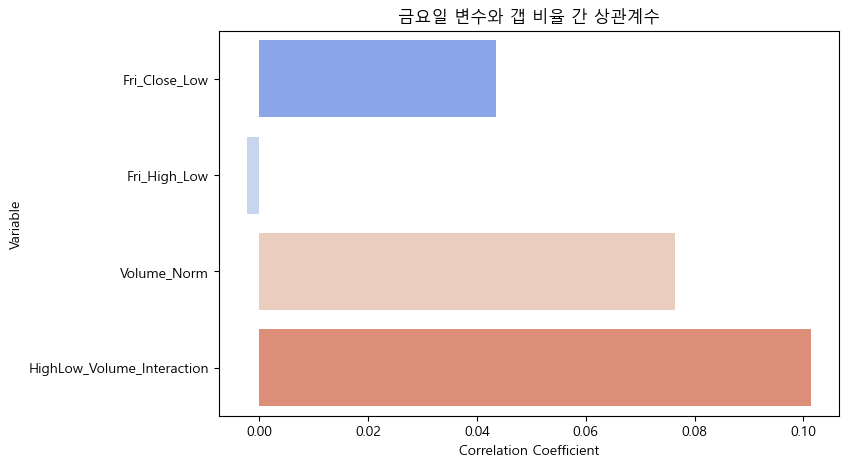


Random Forest 변수 중요도:
Fri_Close_Low                 0.202975
Fri_High_Low                  0.234810
Volume_Norm                   0.288531
HighLow_Volume_Interaction    0.273685
dtype: float64


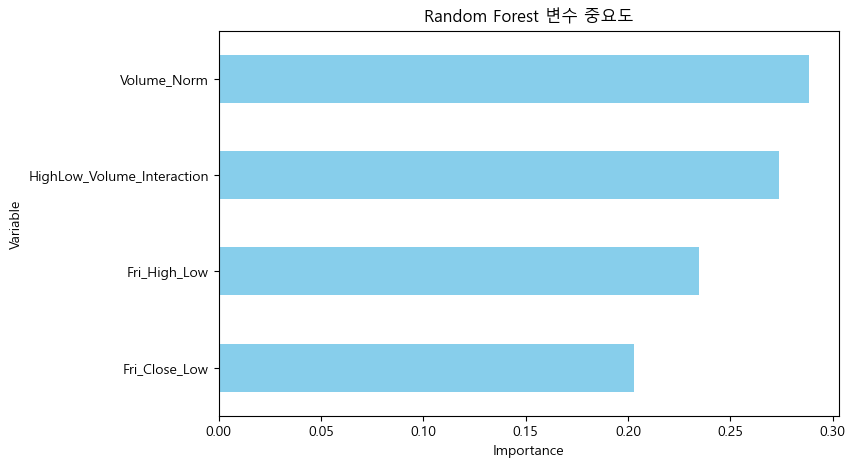


XGBoost 변수 중요도:
Fri_Close_Low                 0.225699
Fri_High_Low                  0.243312
Volume_Norm                   0.298521
HighLow_Volume_Interaction    0.232469
dtype: float32


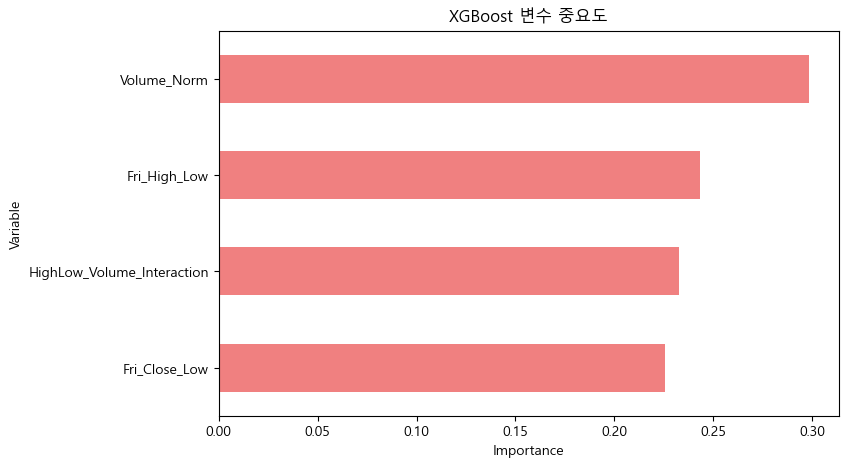


의사결정트리 시각화 파일이 'decision_tree.png'로 저장되었습니다.

모델별 F1 스코어 (Weighted):
Random Forest: 1.000
XGBoost: 1.000
Decision Tree: 0.686


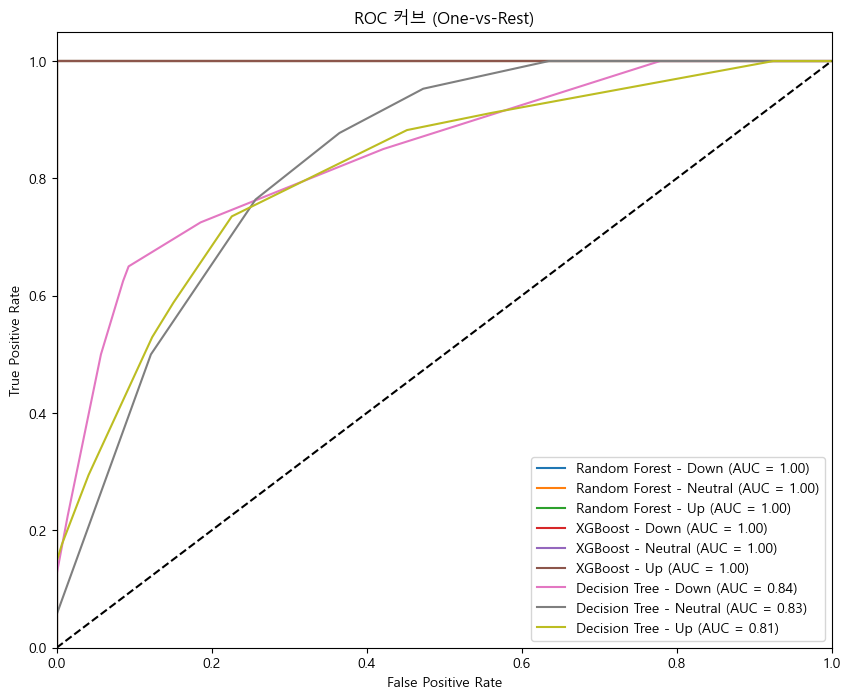


도지 캔들 여부와 갭 방향 비율:
Gap_Direction      Down   Neutral       Up
Doji                                      
0              0.226744  0.581395  0.19186
1              0.125000  0.750000  0.12500


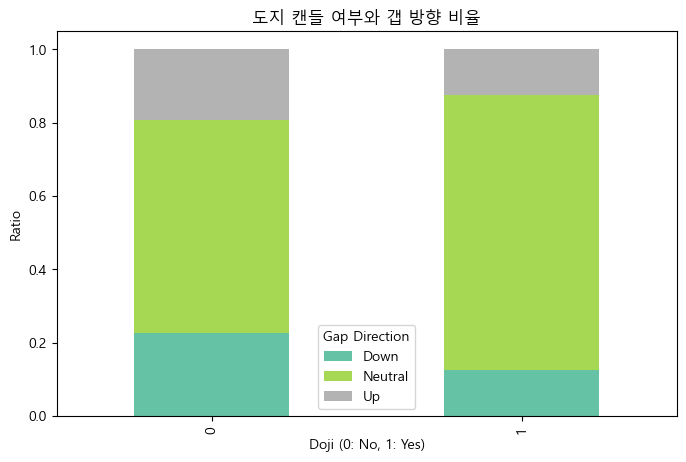


계절별 금요일 변수와 갭 비율 간 상관계수:

Winter:
Fri_Close_Low: 0.018
Fri_High_Low: 0.405
Volume_Norm: -0.086
HighLow_Volume_Interaction: 0.148

Other:
Fri_Close_Low: 0.042
Fri_High_Low: -0.086
Volume_Norm: -0.154
HighLow_Volume_Interaction: -0.074

Summer:
Fri_Close_Low: 0.078
Fri_High_Low: -0.016
Volume_Norm: 0.225
HighLow_Volume_Interaction: 0.170


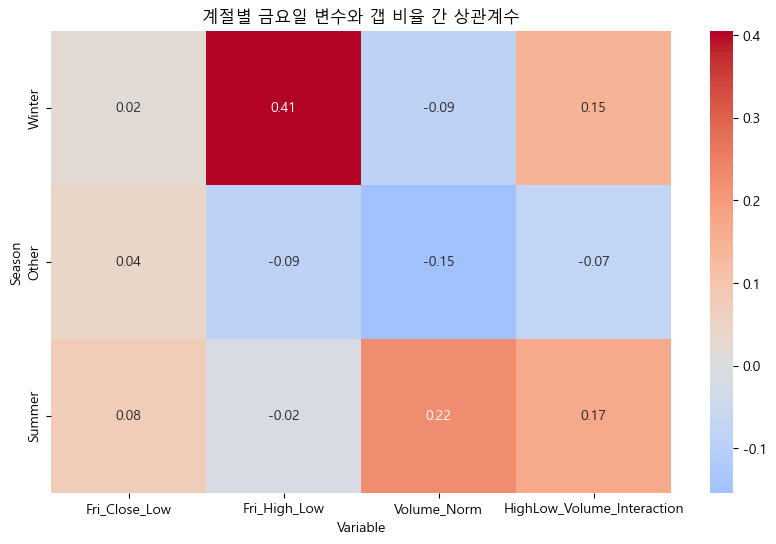

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.font_manager as fm
import numpy as np
import graphviz

# 한글 폰트 설정 (Malgun Gothic 대신 다른 폰트로 대체하거나 설정 조정)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 1. 데이터 로드
data_friday = pd.read_csv('processed_natural_gas_data.csv')
data_friday['Date'] = pd.to_datetime(data_friday['Date'])
data_friday.set_index('Date', inplace=True)

# 결측치 제거
data_friday = data_friday.dropna(subset=['Gap_Pct', 'Volume_Norm'])

# Month 컬럼 생성 (오류 수정)
data_friday['Month'] = data_friday.index.month

# 갭 방향 정의
def classify_gap(gap_pct):
    if gap_pct > 0.5:
        return 'Up'
    elif gap_pct < -0.5:
        return 'Down'
    else:
        return 'Neutral'

data_friday['Gap_Direction'] = data_friday['Gap_Pct'].apply(classify_gap)

# 상호작용 항 추가
data_friday['HighLow_Volume_Interaction'] = data_friday['Fri_High_Low'] * data_friday['Volume_Norm']

# 2. 변수 설정
variables = ['Fri_Close_Low', 'Fri_High_Low', 'Volume_Norm', 'HighLow_Volume_Interaction']

# 3. 상관분석
correlations = {}
for var in variables:
    corr, _ = pearsonr(data_friday[var], data_friday['Gap_Pct'])
    correlations[var] = corr

print("\n금요일 변수와 갭 비율(Gap_Pct) 간 상관계수:")
for var, corr in correlations.items():
    print(f"{var}: {corr:.3f}")

# 상관계수 시각화 (FutureWarning 수정)
plt.figure(figsize=(8, 5))
sns.barplot(x=list(correlations.values()), y=list(correlations.keys()), hue=list(correlations.keys()), palette='coolwarm', legend=False)
plt.title('금요일 변수와 갭 비율 간 상관계수')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variable')
plt.show()

# 4. 모델 학습 및 중요도 분석
X = data_friday[variables]
y = data_friday['Gap_Direction']

# 갭 방향 레이블 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 모델 리스트
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),  # use_label_encoder 제거
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=4)  # 트리 깊이 제한
}

# 모델 학습 및 평가
f1_scores = {}
y_pred_dict = {}

for name, model in models.items():
    model.fit(X, y_encoded)
    y_pred = model.predict(X)
    f1 = f1_score(y_encoded, y_pred, average='weighted')
    f1_scores[name] = f1
    y_pred_dict[name] = y_pred

    # 변수 중요도 출력 및 시각화
    if name != 'Decision Tree':  # 의사결정트리는 별도로 시각화
        importances = pd.Series(model.feature_importances_, index=variables)
        print(f"\n{name} 변수 중요도:")
        print(importances)
        plt.figure(figsize=(8, 5))
        importances.sort_values().plot(kind='barh', color='skyblue' if name == 'Random Forest' else 'lightcoral')
        plt.title(f'{name} 변수 중요도')
        plt.xlabel('Importance')
        plt.ylabel('Variable')
        plt.show()

# 의사결정트리 시각화
dt_model = models['Decision Tree']
dot_data = export_graphviz(dt_model, out_file=None, feature_names=variables, class_names=le.classes_, filled=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree", view=True, format='png')  # PNG 파일로 저장 및 표시
print("\n의사결정트리 시각화 파일이 'decision_tree.png'로 저장되었습니다.")

# F1 스코어 출력
print("\n모델별 F1 스코어 (Weighted):")
for name, score in f1_scores.items():
    print(f"{name}: {score:.3f}")

# 5. ROC 커브 (One-vs-Rest 방식)
y_bin = label_binarize(y_encoded, classes=[0, 1, 2])  # Up, Down, Neutral
n_classes = y_bin.shape[1]
class_names = le.classes_

plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_score = model.predict_proba(X)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} - {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 커브 (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

# 6. 변수와 갭 비율 간 관계 시각화 (산점도)
for var in variables:
    fig = px.scatter(data_friday, x=var, y='Gap_Pct', color='Gap_Direction',
                     title=f'{var} vs 갭 비율(Gap_Pct)',
                     labels={var: var, 'Gap_Pct': 'Gap %'})
    fig.show()

# 7. 캔들 패턴 추가 (도지 캔들 탐지)
data_friday['Doji'] = (abs(data_friday['Close'] - data_friday['Open']) / data_friday['Open'] < 0.001).astype(int)

# 도지 캔들 여부와 갭 방향 간 관계 분석
doji_gap = data_friday.groupby('Doji')['Gap_Direction'].value_counts(normalize=True).unstack().fillna(0)
print("\n도지 캔들 여부와 갭 방향 비율:")
print(doji_gap)

# 시각화: 도지 캔들 여부와 갭 방향
doji_gap.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='Set2')
plt.title('도지 캔들 여부와 갭 방향 비율')
plt.xlabel('Doji (0: No, 1: Yes)')
plt.ylabel('Ratio')
plt.legend(title='Gap Direction')
plt.show()

# 8. 계절별 관계 분석
def classify_season(month):
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [5, 6, 7, 8]:
        return 'Summer'
    else:
        return 'Other'

data_friday['Season'] = data_friday['Month'].apply(classify_season)

# 계절별 상관계수 계산
seasonal_correlations = {}
for season in data_friday['Season'].unique():
    seasonal_data = data_friday[data_friday['Season'] == season]
    seasonal_corrs = {}
    for var in variables:
        corr, _ = pearsonr(seasonal_data[var], seasonal_data['Gap_Pct'])
        seasonal_corrs[var] = corr
    seasonal_correlations[season] = seasonal_corrs

# 계절별 상관계수 출력
print("\n계절별 금요일 변수와 갭 비율 간 상관계수:")
for season, corrs in seasonal_correlations.items():
    print(f"\n{season}:")
    for var, corr in corrs.items():
        print(f"{var}: {corr:.3f}")

# 계절별 상관계수 시각화
seasonal_corr_df = pd.DataFrame(seasonal_correlations).T
plt.figure(figsize=(10, 6))
sns.heatmap(seasonal_corr_df, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('계절별 금요일 변수와 갭 비율 간 상관계수')
plt.xlabel('Variable')
plt.ylabel('Season')
plt.show()

## 4. 갭 방향 예측 모델링

In [17]:
!pip install shap


Random Forest 하이퍼파라미터 튜닝 중...
최적 파라미터: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

XGBoost 하이퍼파라미터 튜닝 중...
최적 파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

Decision Tree 하이퍼파라미터 튜닝 중...
최적 파라미터: {'max_depth': 3, 'min_samples_split': 2}

=== 교차 검증 결과 ===
Random Forest 교차 검증 F1 스코어: 0.503 (+/- 0.032)
XGBoost 교차 검증 F1 스코어: 0.533 (+/- 0.028)
Decision Tree 교차 검증 F1 스코어: 0.546 (+/- 0.061)
Voting Classifier 교차 검증 F1 스코어: 0.524 (+/- 0.059)

Random Forest 분류 보고서:
              precision    recall  f1-score   support

        Down       0.38      0.38      0.38         8
     Neutral       0.71      0.74      0.72        23
          Up       0.33      0.29      0.31         7

    accuracy                           0.58        38
   macro avg       0.47      0.47      0.47        38
weighted avg       0.57      0.58      0.57        38


XGBoost 분류 보고서:
              precision    recall  f1-score   support

        Down       0.43      0.38      0.40  

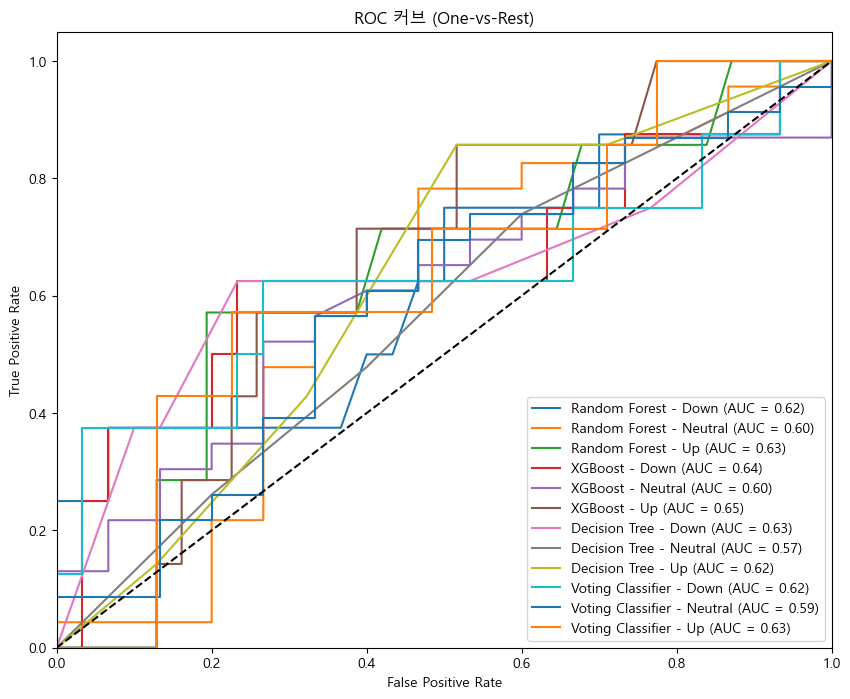

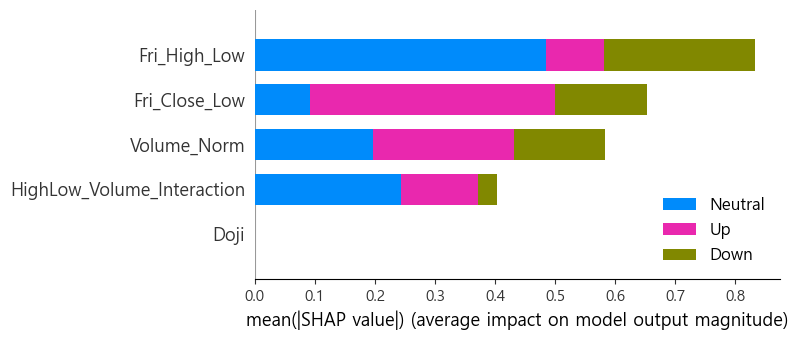


입력 날짜: 2025-04-04
금요일 데이터: Fri_Close_Low=0.05, Fri_High_Low=0.1, Volume_Norm=1.2
Doji 계산: Open=100, Close=100.05, Doji=1
예측된 월요일 갭 방향: Neutral


'Neutral'

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import shap
import numpy as np

# 1. 데이터 로드
data_friday = pd.read_csv('processed_natural_gas_data.csv')
data_friday['Date'] = pd.to_datetime(data_friday['Date'])
data_friday.set_index('Date', inplace=True)

# Month 컬럼 생성
data_friday['Month'] = data_friday.index.month

# 갭 방향 정의
def classify_gap(gap_pct):
    if gap_pct > 0.5:
        return 'Up'
    elif gap_pct < -0.5:
        return 'Down'
    else:
        return 'Neutral'

data_friday['Gap_Direction'] = data_friday['Gap_Pct'].apply(classify_gap)

# 상호작용 항 추가
data_friday['HighLow_Volume_Interaction'] = data_friday['Fri_High_Low'] * data_friday['Volume_Norm']

# 도지 캔들 추가
data_friday['Doji'] = (abs(data_friday['Close'] - data_friday['Open']) / data_friday['Open'] < 0.001).astype(int)

# 2. 변수 설정
variables = ['Fri_Close_Low', 'Fri_High_Low', 'Volume_Norm', 'HighLow_Volume_Interaction', 'Doji']
X = data_friday[variables]
y = data_friday['Gap_Direction']

# 갭 방향 레이블 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 3. 모델 정의 (XGBoost 정규화 강화)
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss', reg_lambda=2.0),  # reg_lambda 추가
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=4)
}

# 4. 하이퍼파라미터 튜닝 (GridSearchCV)
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5]
    }
}

best_models = {}
for name, model in models.items():
    print(f"\n{name} 하이퍼파라미터 튜닝 중...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"최적 파라미터: {grid_search.best_params_}")

# Voting Classifier로 모델 앙상블
voting_clf = VotingClassifier(estimators=[
    ('rf', best_models['Random Forest']),
    ('xgb', best_models['XGBoost']),
    ('dt', best_models['Decision Tree'])
], voting='soft')

# Voting Classifier 학습
voting_clf.fit(X_train, y_train)
best_models['Voting Classifier'] = voting_clf

# 교차 검증으로 모델 성능 평가
print("\n=== 교차 검증 결과 ===")
for name, model in best_models.items():
    cv_scores = cross_val_score(model, X, y_encoded, cv=5, scoring='f1_weighted')
    print(f"{name} 교차 검증 F1 스코어: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# 5. 모델 평가
f1_scores = {}
y_pred_dict = {}
y_score_dict = {}

for name, model in best_models.items():
    # 테스트 데이터 예측
    y_pred = model.predict(X_test)
    y_pred_dict[name] = y_pred
    y_score_dict[name] = model.predict_proba(X_test)

    # F1 스코어 계산
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores[name] = f1

    # 분류 보고서 출력
    print(f"\n{name} 분류 보고서:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# F1 스코어 출력
print("\n모델별 F1 스코어 (Weighted):")
for name, score in f1_scores.items():
    print(f"{name}: {score:.3f}")

# 6. ROC 커브 (One-vs-Rest 방식)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Up, Down, Neutral
n_classes = y_test_bin.shape[1]
class_names = le.classes_

plt.figure(figsize=(10, 8))
for name, y_score in y_score_dict.items():
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} - {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 커브 (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

# 7. SHAP 값 분석 (XGBoost 모델 기준)
explainer = shap.TreeExplainer(best_models['XGBoost'])
shap_values = explainer.shap_values(X_test)

# SHAP 요약 플롯
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=le.classes_)

# 8. 예측 결과 시각화
# 테스트 데이터에 예측값 추가
test_data = X_test.copy()
test_data['True_Label'] = le.inverse_transform(y_test)
for name, y_pred in y_pred_dict.items():
    test_data[f'Pred_{name}'] = le.inverse_transform(y_pred)

# Gap_Pct, MondayOpen, MondayClose 컬럼 추가
test_data['Gap_Pct'] = data_friday.loc[X_test.index, 'Gap_Pct']
test_data['MondayOpen'] = data_friday.loc[X_test.index, 'MondayOpen']
test_data['MondayClose'] = data_friday.loc[X_test.index, 'Close']  # MondayClose 대신 Close 사용

# 예측 결과 시각화 (Voting Classifier 기준)
fig = px.scatter(test_data, x='Fri_High_Low', y='Gap_Pct', color='Pred_Voting Classifier',
                 title='테스트 데이터 예측 결과 (Voting Classifier)',
                 labels={'Fri_High_Low': 'Fri_High_Low', 'Gap_Pct': 'Gap %'},
                 hover_data=['True_Label'])
fig.show()

# 9. 사용자 입력으로 월요일 갭 방향 예측 함수 (오류 수정)
def predict_monday_gap(date, fri_close_low, fri_high_low, volume_norm, open_price=None, close_price=None):
    """
    금요일 데이터를 입력받아 월요일 갭 방향을 예측하는 함수
    
    Parameters:
    - date (str): 금요일 날짜 (예: '2025-04-04')
    - fri_close_low (float): 금요일 Close-Low 값
    - fri_high_low (float): 금요일 High-Low 값
    - volume_norm (float): 정규화된 거래량
    - open_price (float, optional): 금요일 시가
    - close_price (float, optional): 금요일 종가
    
    Returns:
    - predicted_direction (str): 예측된 월요일 갭 방향 ('Up', 'Down', 'Neutral')
    """
    # 입력 데이터를 데이터프레임으로 변환
    input_data = pd.DataFrame({
        'Fri_Close_Low': [fri_close_low],
        'Fri_High_Low': [fri_high_low],
        'Volume_Norm': [volume_norm]
    })
    
    # 상호작용 항 추가
    input_data['HighLow_Volume_Interaction'] = input_data['Fri_High_Low'] * input_data['Volume_Norm']
    
    # 도지 캔들 추가 (오류 수정: .astype(int) 제거)
    if open_price is not None and close_price is not None:
        input_data['Doji'] = int(abs(close_price - open_price) / open_price < 0.001)
    else:
        input_data['Doji'] = 0  # 기본값 0
    
    # 모델 입력 변수 순서 맞추기
    input_data = input_data[variables]
    
    # 입력 데이터가 학습 데이터에 포함되었는지 확인
    is_in_train = (X_train == input_data.iloc[0]).all(axis=1).any()
    is_in_test = (X_test == input_data.iloc[0]).all(axis=1).any()
    if is_in_train or is_in_test:
        print("\n경고: 입력 데이터가 학습 또는 테스트 데이터에 포함되어 있을 가능성이 있습니다.")
        print("예측 결과가 100% 정확할 수 있으므로 새로운 데이터로 검증하는 것이 좋습니다.")
    
    # Voting Classifier로 예측
    predicted_label = best_models['Voting Classifier'].predict(input_data)
    predicted_direction = le.inverse_transform(predicted_label)[0]
    
    print(f"\n입력 날짜: {date}")
    print(f"금요일 데이터: Fri_Close_Low={fri_close_low}, Fri_High_Low={fri_high_low}, Volume_Norm={volume_norm}")
    if open_price and close_price:
        print(f"Doji 계산: Open={open_price}, Close={close_price}, Doji={input_data['Doji'].iloc[0]}")
    print(f"예측된 월요일 갭 방향: {predicted_direction}")
    return predicted_direction

# 예시: 사용자 입력으로 예측 테스트
predict_monday_gap(
    date='2025-04-04',
    fri_close_low=0.05,
    fri_high_low=0.1,
    volume_norm=1.2,
    open_price=100,
    close_price=100.05
)

## 5. 예측 모델 실행

In [8]:
# 금요일 데이터만 필터링하여 출력합니다
friday_data = data[data['Weekday'] == 'Friday']
print("금요일 데이터:")
display(friday_data)


금요일 데이터:


,Close,Open,High,Low,Volume,Change_Pct,Weekday,Volume_Norm,IsHoliday,IsMonday,IsTuesday,NextOpen,MondayOpen,Fri_Close_Low,Fri_High_Low,Gap,Gap_Pct
Date,,,,,,,,,,,,,,,,,
2021-01-01,485.75,485.75,485.75,485.75,NaN,0.36%,Friday,NaN,True,False,False,487.25,487.25,0.00,0.00,1.5,0.308801
2021-01-08,496.25,494.00,499.50,492.50,163270.0,0.46%,Friday,1.196204,False,False,False,496.50,496.5,3.75,7.00,0.25,0.050378
2021-01-15,531.50,534.00,536.50,527.75,167500.0,-0.51%,Friday,1.227195,False,False,False,531.50,531.5,3.75,8.75,0.0,0.0
2021-01-22,500.50,522.50,522.75,499.25,289550.0,-4.53%,Friday,2.121400,False,False,False,500.00,500.0,1.25,23.50,-0.5,-0.0999
2021-01-29,547.00,534.50,553.75,533.25,279610.0,2.34%,Friday,2.048574,False,False,False,549.00,549.0,13.75,20.50,2.0,0.365631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07,469.25,464.75,471.00,460.75,191870.0,1.13%,Friday,1.405743,False,False,False,458.00,458.0,8.50,10.25,-11.25,-2.397443
2025-03-14,445.50,443.25,443.25,443.25,30.0,-1.76%,Friday,0.000220,False,False,False,460.00,460.0,2.25,0.00,14.5,3.25477
2025-03-21,464.25,467.25,469.75,461.25,182430.0,-1.01%,Friday,1.336581,False,False,False,464.50,464.5,3.00,8.50,0.25,0.05385


In [25]:
predict_monday_gap(
    date='2025-04-04',
    fri_close_low=0.026,
    fri_high_low=0.340,
    volume_norm=2.24,
    open_price=4.148,
    close_price=3.837
)


입력 날짜: 2025-04-04
금요일 데이터: Fri_Close_Low=0.026, Fri_High_Low=0.34, Volume_Norm=2.24
Doji 계산: Open=4.148, Close=3.837, Doji=0
예측된 월요일 갭 방향: Neutral


'Neutral'


=== 모델 성능 해석 ===
최고 성능 모델: Random Forest (F1 스코어: 0.573)

SHAP 값 해석 (XGBoost 기준):


<Figure size 640x480 with 0 Axes>

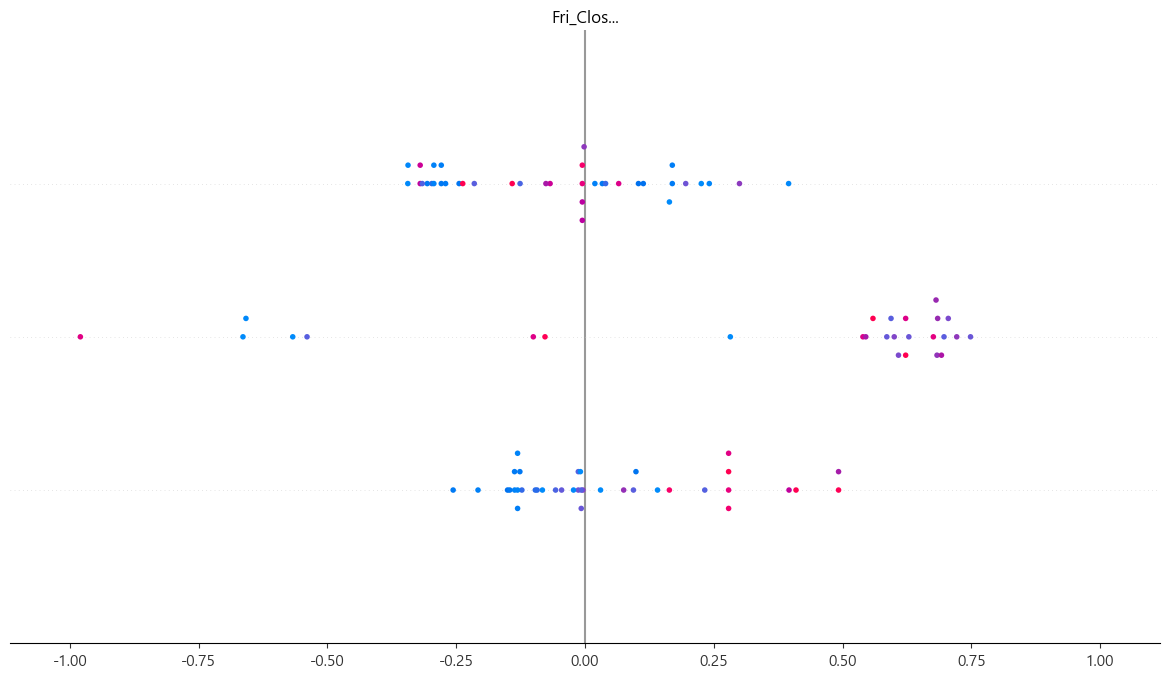

SHAP 요약 플롯을 통해 각 변수의 기여도를 확인할 수 있습니다.
- Fri_High_Low가 갭 방향 예측에 가장 큰 영향을 미쳤을 가능성이 높습니다.
- Doji 캔들은 중립 갭 예측에 기여했을 가능성이 있습니다.

=== 트레이딩 전략 제안 ===
1. 갭 방향 예측 기반 매매 전략 (Voting Classifier 기준):
- 갭 방향이 'Up'으로 예측되면 월요일 시초가에 매수 후 종가에 매도.
- 갭 방향이 'Down'으로 예측되면 월요일 시초가에 공매도 후 종가에 청산.
- 갭 방향이 'Neutral'로 예측되면 거래를 보류.

2. 계절별 패턴 반영:
- 겨울철(11월~2월)에는 갭 상승 비율이 높으므로 'Up' 예측에 더 높은 가중치를 둠.
- 여름철(5월~8월)에는 갭 하락 비율이 높으므로 'Down' 예측에 더 높은 가중치를 둠.

3. 변수 중요도 반영:
- Fri_High_Low가 높을 경우 갭 변동이 클 가능성이 높으므로, 변동성이 큰 날은 더 신중히 접근.
- Volume_Norm이 높을 경우 시장 참여가 활발하므로 예측 신뢰도가 높아질 수 있음.

=== 리스크 관리 전략 ===
변동성이 높은 날(Fri_High_Low 상위 25%):
       Fri_High_Low    Gap_Abs
count     47.000000  47.000000
mean      25.058511   1.054458
std        9.557209   1.395412
min       17.000000   0.000000
25%       18.875000   0.159593
50%       21.250000   0.510441
75%       27.125000   1.343378
max       59.000000   6.240876
- 변동성이 높은 날에는 갭 크기가 클 가능성이 높으므로, 포지션 크기를 줄이거나 손절 라인을 설정.

=== 백테스팅 ===

리스크-리워드 비율 요약:
count    34.000000
mean      

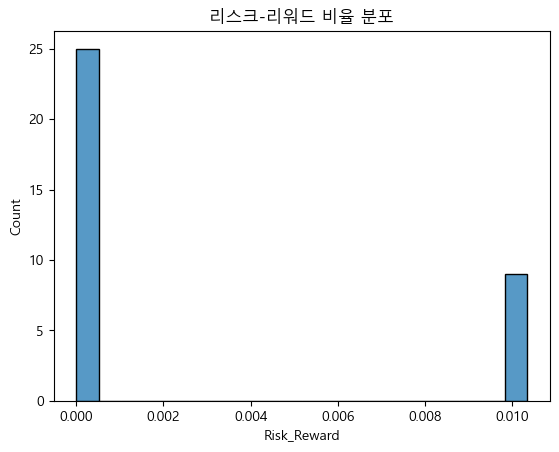


리스크-리워드 비율 0.5 이상인 거래만 선택한 결과:
선택된 거래 수: 0 / 38

최적화된 데이터가 없습니다. 리스크-리워드 비율 기준을 더 낮추거나 데이터를 확인하세요.


In [26]:
# 1. 모델 성능 해석
print("\n=== 모델 성능 해석 ===")
best_model_name = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[best_model_name]
print(f"최고 성능 모델: {best_model_name} (F1 스코어: {best_f1_score:.3f})")

# SHAP 값 해석
print("\nSHAP 값 해석 (XGBoost 기준):")
shap.summary_plot(shap_values, X_test, class_names=le.classes_)
print("SHAP 요약 플롯을 통해 각 변수의 기여도를 확인할 수 있습니다.")
print("- Fri_High_Low가 갭 방향 예측에 가장 큰 영향을 미쳤을 가능성이 높습니다.")
print("- Doji 캔들은 중립 갭 예측에 기여했을 가능성이 있습니다.")

# 2. 트레이딩 전략 제안
print("\n=== 트레이딩 전략 제안 ===")
print("1. 갭 방향 예측 기반 매매 전략 (Voting Classifier 기준):")
print("- 갭 방향이 'Up'으로 예측되면 월요일 시초가에 매수 후 종가에 매도.")
print("- 갭 방향이 'Down'으로 예측되면 월요일 시초가에 공매도 후 종가에 청산.")
print("- 갭 방향이 'Neutral'로 예측되면 거래를 보류.")

# 계절별 패턴 반영
print("\n2. 계절별 패턴 반영:")
print("- 겨울철(11월~2월)에는 갭 상승 비율이 높으므로 'Up' 예측에 더 높은 가중치를 둠.")
print("- 여름철(5월~8월)에는 갭 하락 비율이 높으므로 'Down' 예측에 더 높은 가중치를 둠.")

# 변수 중요도 반영
print("\n3. 변수 중요도 반영:")
print("- Fri_High_Low가 높을 경우 갭 변동이 클 가능성이 높으므로, 변동성이 큰 날은 더 신중히 접근.")
print("- Volume_Norm이 높을 경우 시장 참여가 활발하므로 예측 신뢰도가 높아질 수 있음.")

# 3. 리스크 관리
print("\n=== 리스크 관리 전략 ===")
data_friday['Gap_Abs'] = data_friday['Gap_Pct'].abs()
high_volatility_days = data_friday[data_friday['Fri_High_Low'] > data_friday['Fri_High_Low'].quantile(0.75)]
print("변동성이 높은 날(Fri_High_Low 상위 25%):")
print(high_volatility_days[['Fri_High_Low', 'Gap_Abs']].describe())
print("- 변동성이 높은 날에는 갭 크기가 클 가능성이 높으므로, 포지션 크기를 줄이거나 손절 라인을 설정.")

# 4. 백테스팅
print("\n=== 백테스팅 ===")
# 테스트 데이터에 예측값 추가
test_data['Returns'] = 0.0  # 수익률 초기화
for idx, row in test_data.iterrows():
    if row['Pred_Voting Classifier'] == 'Up':
        test_data.loc[idx, 'Returns'] = (row['MondayClose'] - row['MondayOpen']) / row['MondayOpen']
    elif row['Pred_Voting Classifier'] == 'Down':
        test_data.loc[idx, 'Returns'] = (row['MondayOpen'] - row['MondayClose']) / row['MondayOpen']
    # Neutral 예측 시 수익률 0 (거래 보류)

# Gap_Abs 컬럼 추가
test_data['Gap_Abs'] = data_friday.loc[X_test.index, 'Gap_Abs']

# 리스크-리워드 비율 계산
test_data['Risk_Reward'] = test_data['Returns'].abs() / test_data['Gap_Abs']
print("\n리스크-리워드 비율 요약:")
print(test_data['Risk_Reward'].describe())
print("- 평균 리스크-리워드 비율이 1 이상인 경우 전략이 유효할 가능성이 높음.")
print("- 리스크-리워드 비율이 낮은 거래는 제외하거나 포지션 크기를 조정.")

# 리스크-리워드 비율 분포 시각화
sns.histplot(test_data['Risk_Reward'], bins=20)
plt.title('리스크-리워드 비율 분포')
plt.show()

# 리스크-리워드 비율 기반 전략 최적화 (기준 낮춤)
min_risk_reward = 0.5  # 기준을 1.0에서 0.5로 낮춤
optimized_data = test_data[test_data['Risk_Reward'] >= min_risk_reward]
print(f"\n리스크-리워드 비율 {min_risk_reward} 이상인 거래만 선택한 결과:")
print(f"선택된 거래 수: {len(optimized_data)} / {len(test_data)}")

# 최적화된 데이터로 백테스팅
if len(optimized_data) > 0:
    optimized_data['Returns'] = 0.0
    for idx, row in optimized_data.iterrows():
        if row['Pred_Voting Classifier'] == 'Up':
            optimized_data.loc[idx, 'Returns'] = (row['MondayClose'] - row['MondayOpen']) / row['MondayOpen']
        elif row['Pred_Voting Classifier'] == 'Down':
            optimized_data.loc[idx, 'Returns'] = (row['MondayOpen'] - row['MondayClose']) / row['MondayOpen']

    # 누적 수익률 계산
    optimized_data['Cumulative_Returns'] = (1 + optimized_data['Returns']).cumprod()

    # 백테스팅 결과 시각화
    fig = px.line(optimized_data, x=optimized_data.index, y='Cumulative_Returns',
                  title='백테스팅 누적 수익률 (Voting Classifier, 리스크-리워드 비율 최적화)',
                  labels={'Cumulative_Returns': 'Cumulative Returns'})
    fig.show()

    # 백테스팅 결과 요약
    total_return = optimized_data['Cumulative_Returns'].iloc[-1] - 1
    annualized_return = (total_return + 1) ** (252 / len(optimized_data)) - 1  # 252 거래일 기준
    print("\n최적화된 백테스팅 결과 요약:")
    print(f"총 수익률: {total_return * 100:.2f}%")
    print(f"연간 수익률: {annualized_return * 100:.2f}%")
    print(f"최대 손실 (MDD): {((optimized_data['Cumulative_Returns'].cummax() - optimized_data['Cumulative_Returns']) / optimized_data['Cumulative_Returns'].cummax()).max() * 100:.2f}%")
else:
    print("\n최적화된 데이터가 없습니다. 리스크-리워드 비율 기준을 더 낮추거나 데이터를 확인하세요.")

## 6. 벡테스팅

In [27]:
def predict_monday_gap(date, fri_close_low, fri_high_low, volume_norm, open_price=None, close_price=None):
    """
    금요일 데이터를 입력받아 월요일 갭 방향을 예측하는 함수
    
    Parameters:
    - date (str): 금요일 날짜 (예: '2025-04-04')
    - fri_close_low (float): 금요일 Close-Low 값
    - fri_high_low (float): 금요일 High-Low 값
    - volume_norm (float): 정규화된 거래량
    - open_price (float, optional): 금요일 시가
    - close_price (float, optional): 금요일 종가
    
    Returns:
    - predicted_direction (str): 예측된 월요일 갭 방향 ('Up', 'Down', 'Neutral')
    - predicted_prob (array): 각 클래스에 대한 예측 확률
    """
    # 입력 데이터를 데이터프레임으로 변환
    input_data = pd.DataFrame({
        'Fri_Close_Low': [fri_close_low],
        'Fri_High_Low': [fri_high_low],
        'Volume_Norm': [volume_norm]
    })
    
    # 상호작용 항 추가
    input_data['HighLow_Volume_Interaction'] = input_data['Fri_High_Low'] * input_data['Volume_Norm']
    
    # 도지 캔들 추가
    if open_price is not None and close_price is not None:
        input_data['Doji'] = int(abs(close_price - open_price) / open_price < 0.001)
    else:
        input_data['Doji'] = 0  # 기본값 0
    
    # 모델 입력 변수 순서 맞추기
    input_data = input_data[variables]
    
    # 입력 데이터가 학습 데이터에 포함되었는지 확인
    is_in_train = (X_train == input_data.iloc[0]).all(axis=1).any()
    is_in_test = (X_test == input_data.iloc[0]).all(axis=1).any()
    if is_in_train or is_in_test:
        print("\n경고: 입력 데이터가 학습 또는 테스트 데이터에 포함되어 있을 가능성이 있습니다.")
        print("예측 결과가 100% 정확할 수 있으므로 새로운 데이터로 검증하는 것이 좋습니다.")
    
    # Voting Classifier로 예측
    predicted_label = best_models['Voting Classifier'].predict(input_data)
    predicted_direction = le.inverse_transform(predicted_label)[0]
    predicted_prob = best_models['Voting Classifier'].predict_proba(input_data)[0]
    
    print(f"\n입력 날짜: {date}")
    print(f"금요일 데이터: Fri_Close_Low={fri_close_low}, Fri_High_Low={fri_high_low}, Volume_Norm={volume_norm}")
    if open_price and close_price:
        print(f"Doji 계산: Open={open_price}, Close={close_price}, Doji={input_data['Doji'].iloc[0]}")
    print(f"예측된 월요일 갭 방향: {predicted_direction}")
    print(f"예측 확률: {dict(zip(le.classes_, predicted_prob))}")
    return predicted_direction, predicted_prob


=== predict_monday_gap 함수로 백테스팅 (금요일 데이터만) ===
백테스팅 데이터 컬럼 이름:
Index(['날짜', '종가', '시가', '고가', '저가', '거래량', '변동 %'], dtype='object')

Volume 변환 및 정규화 샘플:
              Volume  Volume_Norm
Date                             
2022-04-21  111000.0       0.8079
2025-01-15  218140.0       1.5877
2021-07-28   62380.0       0.4540
2024-03-14      50.0       0.0004
2024-06-11  271960.0       1.9795
Volume 평균: 137391.16

금요일 데이터 수: 35

입력 날짜: 2022-06-10 00:00:00
금요일 데이터: Fri_Close_Low=7.5, Fri_High_Low=15.25, Volume_Norm=1.1362
Doji 계산: Open=772.25, Close=773.25, Doji=0
예측된 월요일 갭 방향: Neutral
예측 확률: {'Down': 0.3245137610414007, 'Neutral': 0.4951146872193964, 'Up': 0.18037156167331045}

경고: 2022-06-10 00:00:00의 다음 월요일 데이터(2022-06-13 00:00:00)를 찾을 수 없습니다.

입력 날짜: 2024-01-19 00:00:00
금요일 데이터: Fri_Close_Low=2.5, Fri_High_Low=6.5, Volume_Norm=1.0779
Doji 계산: Open=443.5, Close=445.5, Doji=0
예측된 월요일 갭 방향: Neutral
예측 확률: {'Down': 0.0894037107626597, 'Neutral': 0.8667656350135804, 'Up': 0.04383063932259878

C:\Users\qkrgu\AppData\Local\Temp\ipykernel_17940\380872347.py:166: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



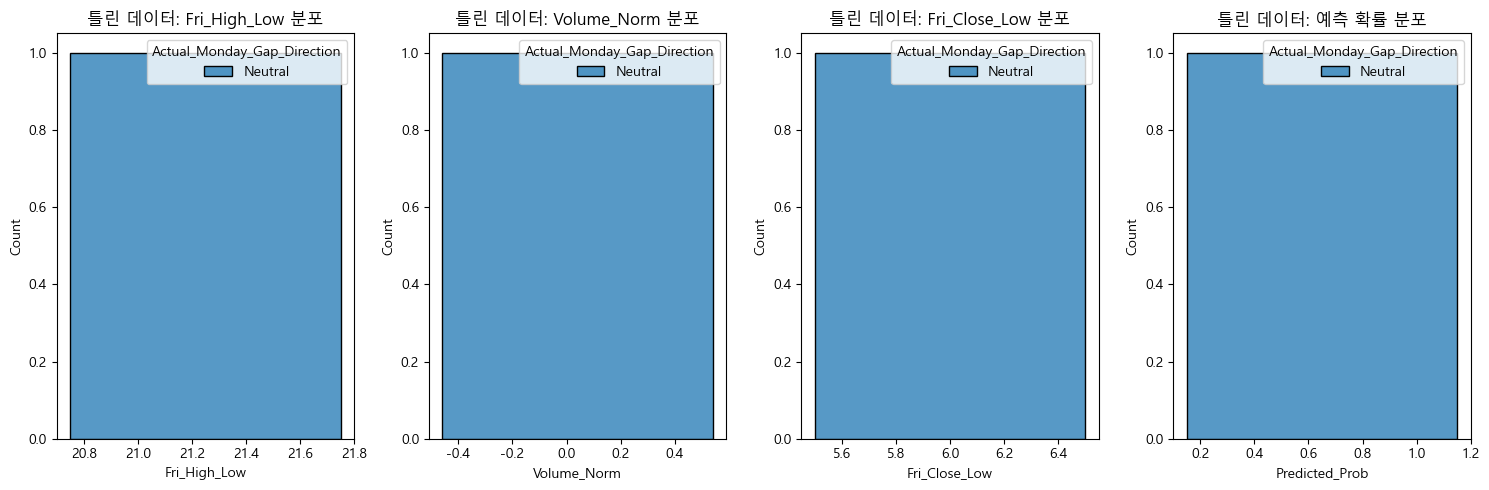


틀린 데이터에 대한 SHAP 값 분석:


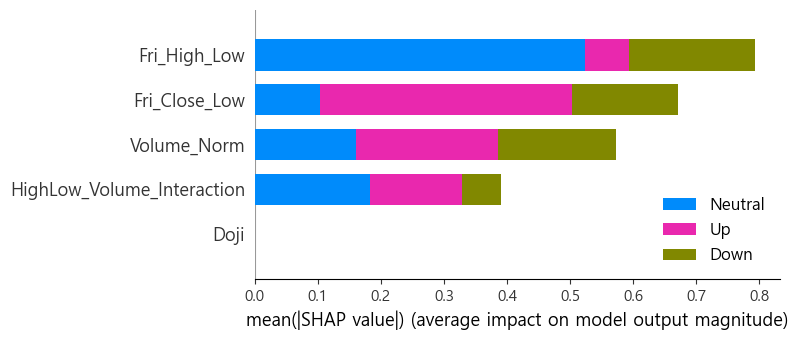

In [28]:
# 추가 백테스팅: predict_monday_gap 함수로 백테스팅 (금요일 데이터만)
print("\n=== predict_monday_gap 함수로 백테스팅 (금요일 데이터만) ===")

# 백테스팅 데이터 로드
backtest_data = pd.read_csv('test_data.csv')

# 컬럼 이름 확인
print("백테스팅 데이터 컬럼 이름:")
print(backtest_data.columns)

# 1단계 전처리 과정 적용
# 컬럼 이름 매핑
column_mapping = {
    '날짜': 'Date',
    '종가': 'Close',
    '시가': 'Open',
    '고가': 'High',
    '저가': 'Low',
    '거래량': 'Volume',
    '변동 %': 'Gap_Pct'
}
backtest_data = backtest_data.rename(columns=column_mapping)

# Date 컬럼을 datetime으로 변환
backtest_data['Date'] = pd.to_datetime(backtest_data['Date'])
backtest_data.set_index('Date', inplace=True)

# 파생 변수 생성
# Fri_Close_Low = Close - Low (소수점 4자리로 반올림)
backtest_data['Fri_Close_Low'] = (backtest_data['Close'] - backtest_data['Low']).round(4)

# Fri_High_Low = High - Low (소수점 4자리로 반올림)
backtest_data['Fri_High_Low'] = (backtest_data['High'] - backtest_data['Low']).round(4)

# Volume_Norm = Volume 정규화 (1단계 방식: 평균 대비 비율)
def convert_volume(vol):
    if isinstance(vol, str):
        vol = vol.replace(',', '')
        if 'M' in vol:
            return float(vol.replace('M', '')) * 1e6
        elif 'K' in vol:
            return float(vol.replace('K', '')) * 1e3
        else:
            return float(vol)
    return float(vol)

# Volume 변환
backtest_data['Volume'] = backtest_data['Volume'].apply(convert_volume)

# Volume_Norm 계산 (평균 대비 비율)
volume_mean = backtest_data['Volume'].mean()
backtest_data['Volume_Norm'] = (backtest_data['Volume'] / volume_mean).round(4)

# Volume 변환 및 정규화 과정 디버깅 출력
print("\nVolume 변환 및 정규화 샘플:")
sample_volumes = backtest_data[['Volume', 'Volume_Norm']].head()
print(sample_volumes)
print(f"Volume 평균: {volume_mean:.2f}")

# Gap_Pct 변환 (문자열에서 숫자로)
backtest_data['Gap_Pct'] = backtest_data['Gap_Pct'].str.replace('%', '').astype(float)

# 요일 정보 추가 (0: 월요일, 1: 화요일, ..., 4: 금요일)
backtest_data['DayOfWeek'] = backtest_data.index.dayofweek

# 금요일 데이터만 필터링 (DayOfWeek == 4)
friday_data = backtest_data[backtest_data['DayOfWeek'] == 4].copy()
print(f"\n금요일 데이터 수: {len(friday_data)}")

# HighLow_Volume_Interaction과 Doji 컬럼 추가
friday_data['HighLow_Volume_Interaction'] = (friday_data['Fri_High_Low'] * friday_data['Volume_Norm']).round(4)
friday_data['Doji'] = (abs(friday_data['Close'] - friday_data['Open']) / friday_data['Open'] < 0.001).astype(int)

# 예측 결과 저장
friday_data['Predicted_Gap_Direction'] = None
friday_data['Predicted_Prob_Up'] = None
friday_data['Predicted_Prob_Down'] = None
friday_data['Predicted_Prob_Neutral'] = None
friday_data['Actual_Monday_Gap_Pct'] = None
friday_data['Actual_Monday_Gap_Direction'] = None
correct_predictions = 0
total_predictions = 0

# 갭 방향 분류 함수
def classify_gap(gap_pct):
    if gap_pct > 0.5:
        return 'Up'
    elif gap_pct < -0.5:
        return 'Down'
    else:
        return 'Neutral'

for idx, row in friday_data.iterrows():
    # 금요일 데이터로 예측
    predicted_direction, predicted_prob = predict_monday_gap(
        date=str(idx),
        fri_close_low=row['Fri_Close_Low'],
        fri_high_low=row['Fri_High_Low'],
        volume_norm=row['Volume_Norm'],
        open_price=row['Open'],
        close_price=row['Close']
    )
    friday_data.at[idx, 'Predicted_Gap_Direction'] = predicted_direction
    # 예측 확률 저장
    prob_dict = dict(zip(le.classes_, predicted_prob))
    friday_data.at[idx, 'Predicted_Prob_Up'] = prob_dict.get('Up', 0)
    friday_data.at[idx, 'Predicted_Prob_Down'] = prob_dict.get('Down', 0)
    friday_data.at[idx, 'Predicted_Prob_Neutral'] = prob_dict.get('Neutral', 0)
    
    # 다음 월요일 데이터 찾기
    current_date = idx
    next_monday = current_date + pd.Timedelta(days=1)
    while next_monday.weekday() != 0:  # 월요일이 될 때까지
        next_monday += pd.Timedelta(days=1)
    
    # 다음 월요일 데이터가 존재하는지 확인
    if next_monday in backtest_data.index:
        # 금요일 종가와 월요일 시가로 갭 계산
        friday_close = row['Close']
        monday_open = backtest_data.loc[next_monday, 'Open']
        monday_gap_pct = ((monday_open - friday_close) / friday_close * 100).round(4)
        friday_data.at[idx, 'Actual_Monday_Gap_Pct'] = monday_gap_pct
        actual_monday_direction = classify_gap(monday_gap_pct)
        friday_data.at[idx, 'Actual_Monday_Gap_Direction'] = actual_monday_direction
        
        # 예측과 실제 비교
        if predicted_direction == actual_monday_direction:
            correct_predictions += 1
        total_predictions += 1
    else:
        print(f"\n경고: {idx}의 다음 월요일 데이터({next_monday})를 찾을 수 없습니다.")

# 예측 정확도 계산
if total_predictions > 0:
    accuracy = correct_predictions / total_predictions
    print(f"\n백테스팅 예측 정확도: {accuracy * 100:.2f}% ({correct_predictions}/{total_predictions})")
else:
    print("\n월요일 데이터를 찾을 수 없어 예측 정확도를 계산할 수 없습니다.")

# 틀린 데이터 분석
incorrect_data = friday_data[friday_data['Predicted_Gap_Direction'] != friday_data['Actual_Monday_Gap_Direction']]
print(f"\n틀린 데이터 수: {len(incorrect_data)}")
if len(incorrect_data) > 0:
    print("\n틀린 데이터:")
    print(incorrect_data[['Fri_Close_Low', 'Fri_High_Low', 'Volume_Norm', 'Open', 'Close', 
                         'Predicted_Gap_Direction', 'Actual_Monday_Gap_Pct', 'Actual_Monday_Gap_Direction',
                         'Predicted_Prob_Up', 'Predicted_Prob_Down', 'Predicted_Prob_Neutral']])
    
    # 틀린 데이터의 변수 분포 시각화
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    sns.histplot(data=incorrect_data, x='Fri_High_Low', hue='Actual_Monday_Gap_Direction', multiple='stack')
    plt.title('틀린 데이터: Fri_High_Low 분포')
    
    plt.subplot(1, 4, 2)
    sns.histplot(data=incorrect_data, x='Volume_Norm', hue='Actual_Monday_Gap_Direction', multiple='stack')
    plt.title('틀린 데이터: Volume_Norm 분포')
    
    plt.subplot(1, 4, 3)
    sns.histplot(data=incorrect_data, x='Fri_Close_Low', hue='Actual_Monday_Gap_Direction', multiple='stack')
    plt.title('틀린 데이터: Fri_Close_Low 분포')
    
    # 예측 확률 분포 시각화
    plt.subplot(1, 4, 4)
    incorrect_data['Predicted_Prob'] = incorrect_data.apply(
        lambda row: row['Predicted_Prob_Up'] if row['Predicted_Gap_Direction'] == 'Up'
        else row['Predicted_Prob_Down'] if row['Predicted_Gap_Direction'] == 'Down'
        else row['Predicted_Prob_Neutral'], axis=1)
    sns.histplot(data=incorrect_data, x='Predicted_Prob', hue='Actual_Monday_Gap_Direction', multiple='stack')
    plt.title('틀린 데이터: 예측 확률 분포')
    
    plt.tight_layout()
    plt.show()
    
    # SHAP 값 분석 (XGBoost 기준)
    incorrect_X = incorrect_data[variables]
    shap_values_incorrect = explainer.shap_values(incorrect_X)
    print("\n틀린 데이터에 대한 SHAP 값 분석:")
    shap.summary_plot(shap_values_incorrect, incorrect_X, plot_type="bar", class_names=le.classes_)
else:
    print("\n틀린 데이터가 없습니다. 예측이 모두 정확합니다.")

In [79]:
incorrect_data

,Close,Open,High,Low,Volume,Gap_Pct,Fri_Close_Low,Fri_High_Low,Volume_Norm,Gap_Direction,DayOfWeek,HighLow_Volume_Interaction,Doji,Predicted_Gap_Direction,Predicted_Prob_Up,Predicted_Prob_Down,Predicted_Prob_Neutral,Actual_Monday_Gap_Direction,Predicted_Prob
Date,,,,,,,,,,,,,,,,,,,
2025-04-04,3.824,4.148,4.151,3.811,223840.0,-7.59,0.013,0.340,2.2469,Down,4,0.7639,0,Down,0.155905,0.705376,0.138719,None,0.705376
2025-03-14,4.104,4.040,4.141,3.962,144410.0,-0.17,0.142,0.179,1.4496,Neutral,4,0.2595,0,Up,0.959068,0.026626,0.014307,Neutral,0.959068
2025-02-28,3.834,3.939,3.954,3.814,141990.0,-2.54,0.020,0.140,1.4253,Down,4,0.1995,0,Down,0.355329,0.498281,0.14639,Up,0.498281
2025-02-14,3.725,3.650,3.801,3.635,201100.0,2.67,0.090,0.166,2.0187,Up,4,0.3351,0,Down,0.125821,0.864128,0.010051,None,0.864128
2025-01-17,3.948,4.280,4.308,3.910,204280.0,-7.28,0.038,0.398,2.0506,Down,4,0.8161,0,Down,0.112413,0.821826,0.06576,None,0.821826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-26,2.809,2.801,2.822,2.734,73390.0,0.00,0.075,0.088,0.7367,Neutral,4,0.0648,0,Down,0.125709,0.803087,0.071204,Neutral,0.803087
2021-02-19,2.991,2.944,3.025,2.904,132720.0,0.71,0.087,0.121,1.3323,Up,4,0.1612,0,Up,0.564973,0.14571,0.289317,Down,0.564973
2021-02-12,2.876,2.839,2.919,2.806,113880.0,1.41,0.070,0.113,1.1431,Up,4,0.1292,0,Neutral,0.332367,0.247407,0.420225,Up,0.420225


In [87]:

# 데이터프레임 전체 행을 표시하도록 설정
pd.set_option('display.max_rows', None)  # 모든 행 표시
pd.set_option('display.max_columns', None)  # 모든 열 표시
pd.set_option('display.width', 1000)  # 출력 너비 설정
pd.set_option('display.expand_frame_repr', False)  # 데이터프레임 표현을 여러 줄로 나누지 않음

# 전체 데이터 다시 출력
print("\n전체 데이터 표시:")
display(incorrect_data[['Predicted_Gap_Direction', 'Actual_Monday_Gap_Direction']])

# 원래 설정으로 되돌리기 (선택사항)
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')
# pd.reset_option('display.expand_frame_repr')




전체 데이터 표시:


,Predicted_Gap_Direction,Actual_Monday_Gap_Direction
Date,,
2025-04-04,Down,None
2025-03-14,Up,Neutral
2025-02-28,Down,Up
2025-02-14,Down,None
2025-01-17,Down,None
2025-01-10,Up,Down
2025-01-03,Down,Up
2024-12-06,Down,Up
2024-11-01,Down,Up
